<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/dnn/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep neural networks (Unfinished)



# Software for deep learning <a class="anchor" id="DL"></a>


Deep learning is about composing differentiable functions into more complex functions, represented as a computation graph, and then using automatic differentiation ("autograd") to compute gradients, which we can pass to an optimizer, to fit the function to data. This is sometimes called "differentiable programming". Furthermore, it is desirable to  execute such computation graphs on hardware accelerators, such as GPUs. We list a few popular libraries which support such functionality below.

All of these libraries are quite similar (convergent evolution!).
The most unique one is JAX, which uses a pure functional programming (stateless) approach. Also, it is much lower level, and gives the user more control (e.g., computing per-example gradients). Overall it provides an experience that is similar to vanilla numpy programming, but much faster (eg using vmap and jit).

<table align="left">
    <tr>
        <th style="text-align:left">Name</th>
      <th style="text-align:left">More info</th>
    <tr> 
        <td style="text-align:left"> <a href="http://www.tensorflow.org">Tensorflow 2.0</a></td>
     <td style="text-align:left"><a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/intro/tf.ipynb">TF notebook</a></td>
    <tr>
        <td style="text-align:left"> <a href="http://pytorch.org">Pytorch 1.0</a></td>
       <td style="text-align:left">
         <a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/intro/pytorch.ipynb">PyTorch notebook</a></td>
               <tr>
        <td style="text-align:left"> <a href="http://github.com/google/jax">JAX</a></td>
            <td style="text-align:left">
              <a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/intro/jax.ipynb">JAX notebook</a></td>
          <tr>
        <td style="text-align:left"> <a href="https://mxnet.apache.org/">MXNet</a></td>
              <td style="text-align:left">
                <a href="http://www.d2l.ai/">  Dive into deep learning book</a></td>    
 </table>
     




In [0]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn
from time import time

In [2]:
# Tensorflow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print("tf version {}".format(tf.__version__))
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("TF cannot find GPU")

TensorFlow 2.x selected.
tf version 2.0.0-rc0
/device:GPU:0


# MLP on Fashion MNIST using TF

In this section, we fit an MLP classifier to Fashion MNIST using TF.


(60000, 28, 28)
(10000, 28, 28)


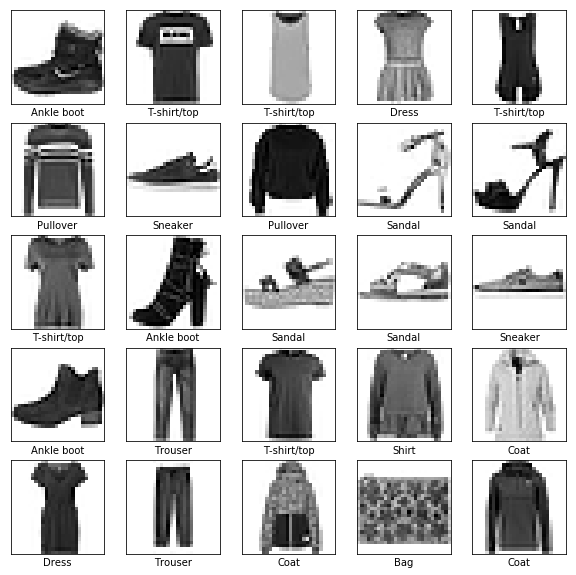

In [19]:
np.random.seed(0)

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

print(np.shape(train_images))
print(np.shape(test_images))
#(60000, 28, 28)
#(10000, 28, 28)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
#save_fig("fashion-mnist-data.pdf")
plt.show()



In [20]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.summary()
    
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# We just train for 2 epochs because (1) it is faster, and
# (2) it produces more errors, which makes for a more interesting plot :)
time_start = time()
model.fit(train_images, train_labels, epochs=2)
print('time spent training {:0.3f}'.format(time() - time_start))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4944 - accuracy: 0.8267
Epoch 2/2
60000/60000 [==============================] - 6s 94us/sample - loss: 0.3743 - accuracy: 0.8652
time spent training 11.850


In [21]:
predictions = model.predict(test_images)
print(np.shape(predictions))

# Overall accuracy
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Train accuracy:', train_acc)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

(10000, 10)
60000/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [22]:
# To apply prediction to a single image, we need to reshape to an (N,D,D) tensor
# where N=1
img = test_images[0]
img = (np.expand_dims(img,0))
print(img.shape)
predictions_single = model.predict(img)
print(predictions_single.shape)

(1, 28, 28)
(1, 10)


In [0]:
def plot_image_and_label(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = np.reshape(img, (28, 28)) # drop any trailing dimension of size 1
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
    plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array)),
                                color=color)
  else:
    color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_label_dist(predictions_array, true_label):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

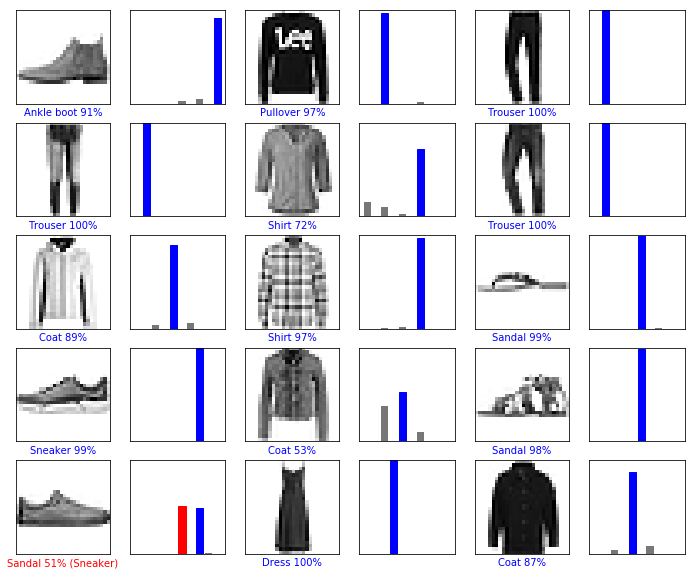

In [24]:

  
# Plot the first 15 test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image_and_label(predictions[i], test_labels[i], test_images[i])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_label_dist(predictions[i], test_labels[i])
#save_fig("fashion-mlp-predictions-2epochs.pdf")
plt.show()

# CNN for Fashion MNIST using TF

In [25]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [0]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# We just train for 2 epochs so we can compare to
# fashion_mlp_tf
time_start = time()
model.fit(train_images, train_labels, epochs=2)
print('time spent training {:0.3f}'.format(time() - time_start))

# Overall accuracy
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Train accuracy:', train_acc)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

predictions = model.predict(test_images)
print(np.shape(predictions))

Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 212us/sample - loss: 0.4951 - accuracy: 0.8173
Epoch 2/2
60000/60000 [==============================] - 12s 204us/sample - loss: 0.3180 - accuracy: 0.8842
time spent training 25.150
60000/1 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

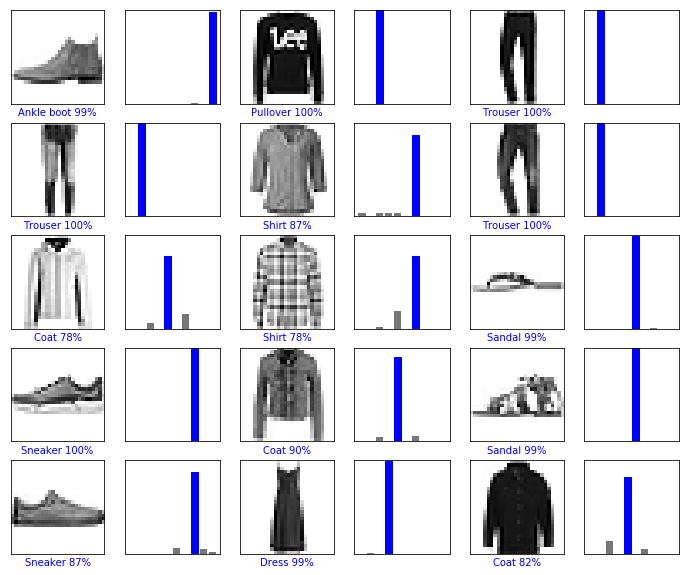

In [28]:
# Plot the first 15 test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image_and_label(predictions[i], test_labels[i], test_images[i])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_label_dist(predictions[i], test_labels[i])
#save_fig("fashion-cnn-predictions.pdf")
plt.show()

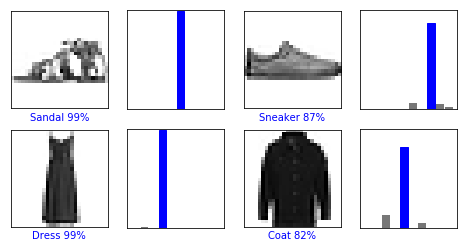

In [29]:
# Plot test images where some errors are made
# to make the histograms of predictions look more itneresting
ndx = [11, 12, 13, 14]
num_rows = 2
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  j = ndx[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image_and_label(predictions[j], test_labels[j], test_images[j])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_label_dist(predictions[j], test_labels[j])
#save_fig("fashion-cnn-predictions-2epochs-errors.pdf")
plt.show()